# Tópicos utilizando TF-IDF / NMF - SToC

Quero q você entenda o que é feito nesse notebook, perguntar se surgir duvidas e melhhorar os tópicos. Talvez utilizando uma menor quantidade de tópicos, tentar nomear os tópicos manualmente. 

**Faça testes utilizando todas palavras do vocabulario (sem usar o parametro stop_words no tfidf) talvez obtenha resultados interessantes**

O que se busca em tópicos: 
- É a coêrencia entree as palavras de um mesmo tópico;
- Um significado para o tópico; (Ele representa algo, ou no caso, alguma área ou áreas)
- É aconselhavel que os tópicos tenham palavras distintas entre si ( Utilizando só as palavras da ACM, é bem dificil de não repetir palavras)
- E caso voce teste para mais de um ano, tenha em mente que deve se utilizar a mesma configuração para todos os anos! Tem que ser genérico para qualquer ano que for executar.

In [1]:
import pandas as pd
import numpy as np
import unicodedata
import statistics
import operator

from fuzzywuzzy import fuzz 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


from sklearn.decomposition import NMF

from SToC import *

import os

from IPython.display import HTML, display
from tabulate import tabulate
from metrics import Evaluation as Eval

from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

/home/leandror/.local/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
pd.set_option('display.max_colwidth',500)

In [3]:
def print_join(iterates, model, W, n_topics, features, n_words):
	more = []
	tops = []

	more2 = []

	for i in range(len(iterates)):
		a = iterates[i][1]
		b = iterates[i][2]

		#mudar

		if ((a<n_topics)&(b>=n_topics)):
			aux = (model[a] + more[b-n_topics])/2
			#aux = more[b-n_topics]
			aux2 = (W[a] + more2[b-n_topics])/2
#
		if ((a>=n_topics)&(b<n_topics)):
			aux = (more[a-n_topics] + model[b])/2
			#aux = model[b]
			aux2 = (more2[a-n_topics] + W[b])/2

		if ((a>=n_topics)&(b>=n_topics)):
			#print a
			#print b
			#print len(more)
			aux = (more[a-n_topics] + more[b-n_topics])/2
			#aux = more[b-n_topics]# + more[b-n_topics])/2
			aux2 = (more2[a-n_topics] + more2[b-n_topics])/2
		
		if ((a < n_topics) & (b < n_topics)):
			aux = (model[a] + model[b])/2
			#aux = model[b]
			aux2 = (W[a] + W[b])/2

			
		#print aux
		more.append(aux)
		more2.append(aux2)
def print_estats(t2):

	valores = []
	for (i,j,k,l) in t2:
		valores.append(l)

	ex =  pd.Series(valores)
	print ("(Max+min)/2: ", (ex.max() + ex.min())/2)
	print ("Media: ", ex.mean())
	print( "Max: ", ex.max())
	print ("Min: ", ex.min())
	print ("Variancia: ", ex.var())
	print ("Desvio Padrao: ", ex.std())
	print ("Desvio Absoluto: ", ex.mad())
	return ex.mean()

def see_join(iterates, W, H, limiar,n_final):

    W = W.transpose()
    H = H.transpose()

    W_dict = {}
    H_dict = {}

    for i in range(len(W)):
        W_dict[i] = W[i]
    
    for i in range(len(H)):
        H_dict[i] = H[i]

	#iterates[i][0] numero do novo topicos
	#iterates[i][1] uniao tópico 1
	#iterates[i][2] uniao topico 2
	#iterates[i][3] valor (limiar)

 

	#iterates = sorted(iterates, key=lambda x: x[3], reverse=True)

	#print iterates
	#exit()
    n_topics = len(W)
    aux_final = len(W)
    print(aux_final)
    for idx,i in enumerate(range(len(iterates))):
        new = iterates[i][0]
        a = iterates[i][1]
        b = iterates[i][2]
        valor = iterates[i][3]
        
        #if valor < limiar:
        #	break

        if aux_final == n_final:
            break

        W_dict[new] = (W_dict[a] + W_dict[b])/2
        del(W_dict[a])
        del(W_dict[b])

        H_dict[new] = (H_dict[a] + H_dict[b])/2
        del(H_dict[a])
        del(H_dict[b])



        aux_final -=1

    W_new = []

    H_new = []

        #print (W_dict.keys())
        #exit()

        #print sorted(W_dict.keys())

    for i in sorted(W_dict.keys()):
        W_new.append(W_dict[i])

    for i in sorted(H_dict.keys()):
        H_new.append(H_dict[i])

    W_ret = np.zeros((len(W_new),len(W_new[0])))
    H_ret = np.zeros((len(H_new),len(H_new[0])))

    for i in range(len(W_new)):
        for j in range(len(W_new[0])):
            W_ret[i][j] = W_new[i][j]

    for i in range(len(H_new)):
        for j in range(len(H_new[0])):
            H_ret[i][j] = H_new[i][j]

    return W_ret,H_ret


In [29]:
def print_top_words_display(H, feature_names, n_top_words):
    table_output = [['Topic','topwords']]
    topics = []
    for topic_idx, topic in enumerate(H):
        top_index = ["Topic # %d" % topic_idx]
        top_words = [" ' ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])]
        values = [value for value in np.sort(topic)[:-n_top_words - 1:-1]]
        table_output.append(top_index + top_words)
        topics.append(" ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
    df_out = pd.DataFrame(table_output, index=None)
    display(HTML(tabulate(table_output, tablefmt='html')))
    return topics,df_out

In [5]:
def execute_tfidf(dataset,max_df=1,min_df=1,ngram=(0,2),stop_words=[]):
    tfidf_vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df,ngram_range=ngram,stop_words=stop_words)
    tfidf = tfidf_vectorizer.fit_transform(dataset)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    return tfidf,tfidf_feature_names

In [6]:
def execute_nmf(tfidf,n_topics = 10,n_components = 5):
    n_topics = n_topics
    n_components = n_components
    nmf = NMF(n_components=n_components,max_iter=400)
    W = nmf.fit_transform(tfidf)
    H = nmf.components_.transpose() 
    return nmf,W,H

In [7]:
def execute_stoc(W,H,n_final,n_components):
    n_words = H.shape[0]

    topXtop_norm = getIrredutibleMatrix(W,H,n_components)
    assign, t2 = joinTopics(n_components, topXtop_norm)


    tops = print_join(t2, H.transpose(), W, n_components, None, n_words)

    limiar = print_estats(t2)

    W_new, H_new = see_join(t2, W, H, limiar,n_final)
    return W_new,H_new

In [8]:
artigos = (open('/home/leandror/new_corpus.txt','r').read().split('\n')[17236:19610])

In [9]:
valor = 0
for i in artigos:
    valor +=len(set(i.split()))
print("Densidade: {0}".format(valor/len(artigos)))

Densidade: 7.164279696714406


In [10]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(artigos)
sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
#print(words_freq)
indices = np.arange(len(words_freq))

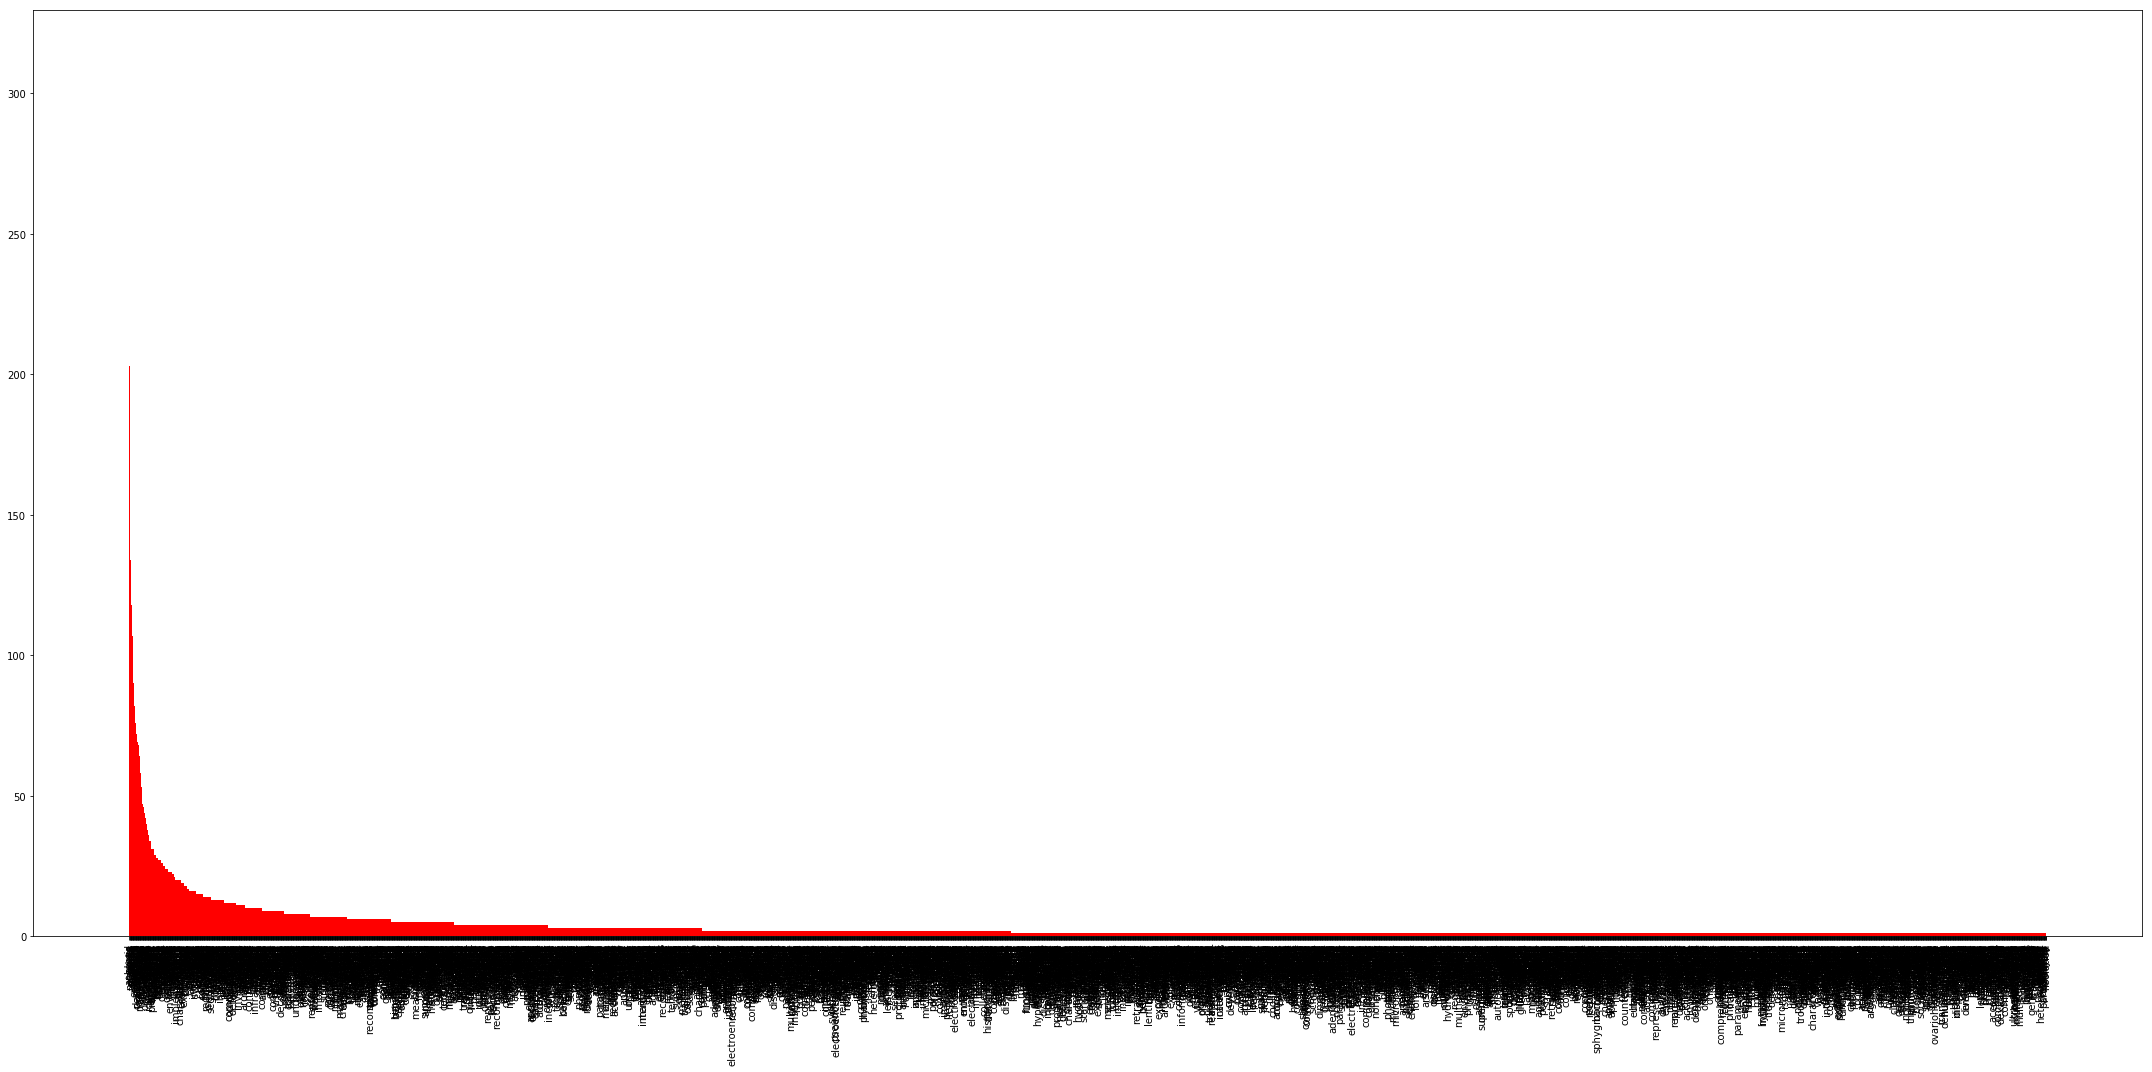

In [11]:
%matplotlib inline

word = []
frequency = []
for i in range(len(words_freq)):
    word.append(words_freq[i][0])
    frequency.append(words_freq[i][1])
plt.figure(figsize=(30, 15))
plt.bar(indices,frequency,width =1, color='r')
plt.xticks(indices, word, rotation='vertical')
plt.tight_layout()
plt.show()


In [13]:
f = open('../acm_words.txt','r')
acm_words = f.read().replace('\n',' ').split()

In [14]:
"""Estou definindo que qualquer palavra que não seja da ACM, seja uma stopword, 
talvez o mais correto a se fazer é definir meu vocabulario como palavras da ACM
Tem um parametro no TFIDF no qual voce escolhe qual o vocabulario para realizar o TF-IDF"""
stop_words_without_acm_words = list(set(word) - set(acm_words))

In [15]:
print("Quantidade de palavras no corpus: {}".format(len(word)))
print("Quantidade de palavras na ACM: {}".format(len(acm_words)))
print("Quantidade de palavras da ACM no corpus: {}".format(len(set(word).intersection(acm_words))))
print("Quantidade de palavras diferentes da ACM no corpus: {}".format(len(stop_words_without_acm_words)))

Quantidade de palavras no corpus: 4613
Quantidade de palavras na ACM: 1524
Quantidade de palavras da ACM no corpus: 979
Quantidade de palavras diferentes da ACM no corpus: 3634


In [136]:
"""Parametros"""
# TF-IDF
# Quando númerico é a quantidade de documentos explicita!!
max_df = 0.85 # Só palavras que aparecem no máximo em 85% dos documentos
min_df = 0.01 # Só palavras que aparecem no minimo em 1% dos documentos
ngram= (1,1)
#NMF
n_components = 10 # Numero de tópicos
n_topics = 10 # Quantidade de palavras para definir o tópico

In [137]:
tfidf,tfidf_feature_names = execute_tfidf(artigos,max_df=max_df,min_df=min_df,ngram=ngram,stop_words = stop_words_without_acm_words)

In [138]:
nmf,W,H = execute_nmf(n_components=n_components,n_topics=n_topics,tfidf=tfidf)

In [139]:
topics_nmf,a = print_top_words_display(H.transpose(), tfidf_feature_names,n_topics)

Topic,topwords
Topic # 0,based ' system ' image ' detection ' models ' classification ' optimization ' control ' framework ' applications
Topic # 1,analysis ' modeling ' image ' network ' process ' health ' identification ' detection ' energy ' performance
Topic # 2,data ' classification ' learning ' mining ' management ' network ' framework ' techniques ' clustering ' cloud
Topic # 3,networks ' neural ' sensor ' wireless ' detection ' network ' management ' performance ' classification ' recognition
Topic # 4,model ' network ' learning ' development ' application ' computing ' generation ' energy ' use ' power
Topic # 5,systems ' control ' detection ' management ' applications ' performance ' energy ' modeling ' support ' applied
Topic # 6,software ' process ' development ' mapping ' engineering ' management ' learning ' assessment ' application ' support
Topic # 7,time ' detection ' applied ' system ' control ' classification ' algorithms ' multi ' quality ' patterns
Topic # 8,evaluation ' design ' performance ' algorithms ' models ' learning ' system ' computing ' cloud ' power
Topic # 9,algorithm ' optimization ' applied ' problems ' network ' search ' models ' estimation ' algorithms ' image


In [21]:
def tf_idf_print(tfidf_coherence):
    print("TF-IDF Coherence Score")
    print("----------------------")
    print("Média: {}".format(statistics.mean(tfidf_coherence)))
    print("Desvio Padrão: {}".format(statistics.stdev(tfidf_coherence)))
    print("Variância: {}".format(statistics.variance(tfidf_coherence)))
    print("Min: {}".format(min(tfidf_coherence)))
    print("Max: {}".format(max(tfidf_coherence)))
    print("----------------------")
    print("")
def pmi_npmi_print(pmi,npmi):
    print("PMI e NPMI Score")
    print("----------------------")
    print("Média: PMI -> {}, NPMI -> {}".format(statistics.mean(pmi),statistics.mean(npmi)))
    print("Desvio Padrão: PMI -> {}, NPMI -> {}".format(statistics.stdev(pmi),statistics.stdev(npmi)))
    print("Variância: PMI -> {}, NPMI -> {}".format(statistics.variance(pmi),statistics.variance(npmi)))
    print("Min: PMI -> {}, NPMI -> {}".format(min(pmi),min(npmi)))
    print("Max: PMI -> {}, NPMI -> {}".format(max(pmi),max(npmi)))
    print("----------------------")

In [22]:
n_terms, words, word_frequency, term_docs = Eval.count(artigos)
tfidf_coherence = Eval.tfidf_coherence(topics_nmf, tfidf, tfidf_feature_names)
pmi, npmi = Eval.pmi(topics_nmf, word_frequency, term_docs,len(artigos), 10)

In [23]:
tf_idf_print(tfidf_coherence)
pmi_npmi_print(pmi,npmi)

TF-IDF Coherence Score
----------------------
Média: -250.4289097809068
Desvio Padrão: 16.69876868743573
Variância: 278.84887567648406
Min: -295.90469269623384
Max: -226.6348947364336
----------------------

PMI e NPMI Score
----------------------
Média: PMI -> 0.5410539939363352, NPMI -> 0.1185263702452468
Desvio Padrão: PMI -> 0.06813255516415231, NPMI -> 0.01835988983491973
Variância: PMI -> 0.004642045073196258, NPMI -> 0.0003370855547503889
Min: PMI -> 0.4424852388291087, NPMI -> 0.09093631493909105
Max: PMI -> 0.6963140511706737, NPMI -> 0.16180993773403654
----------------------


In [32]:
from gensim.models import Word2Vec

In [39]:
model = Word2Vec.load("/home/leandror/word2vec.model")

In [40]:
word_vectors = model.wv
vectors = model.wv.vectors
vector_size = model.wv.vector_size
index2word = model.wv.index2word

In [142]:
table = [['id','topic','area']]
for idx_topic,topic in enumerate(topics_nmf):
    for idx,word in enumerate(topic.split()):
        word_idx = index2word.index(word)
        if idx==0:
            tv = vectors[word_idx]
        else:
            tv += vectors[word_idx] 
        maxi = 0
        area = ''
        for acm in acm_vectors:
            value = cosine_similarity(tv.reshape(1,150),acm_vectors[acm].reshape(1,150))
            if value > maxi:
                maxi = value
                area = acm
    table.append([idx_topic,topic,area])
with open('tabela_first_layer_hierarchy_t10.pickle', 'wb') as handle:
    pickle.dump(table, handle, protocol=pickle.HIGHEST_PROTOCOL)
display(HTML(tabulate(table, tablefmt='html')))

id,topic,area
0,based system image detection models classification optimization control framework applications,information systems
1,analysis modeling image network process health identification detection energy performance,mathematics of computing
2,data classification learning mining management network framework techniques clustering cloud,mathematics of computing
3,networks neural sensor wireless detection network management performance classification recognition,applied computing
4,model network learning development application computing generation energy use power,mathematics of computing
5,systems control detection management applications performance energy modeling support applied,hardware
6,software process development mapping engineering management learning assessment application support,software and its engineering
7,time detection applied system control classification algorithms multi quality patterns,software and its engineering
8,evaluation design performance algorithms models learning system computing cloud power,software and its engineering
9,algorithm optimization applied problems network search models estimation algorithms image,mathematics of computing


In [52]:
import pickle
with open('../../datasets/'+ 'acm_hierachy' + '.pkl', 'rb') as f:
    acm = pickle.load(f)
with open('../../datasets/'+ 'acm_areas' + '.pkl', 'rb') as f:
    areas = pickle.load(f)
with open('../../datasets/'+ 'acm_areas_id' + '.pkl', 'rb') as f:
    areas_id = pickle.load(f)
with open('../../datasets/'+ 'acm_areas_parents' + '.pkl', 'rb') as f:
    areas_parents = pickle.load(f)

In [55]:
def area_parents(area,areas_id,areas_parents,similar_area):
    li_id = getKeysByValue(areas_id,area)
    parents = [areas_parents[i] for i in li_id]
    for li in li_id:
        if li not in similar_area.keys():
            similar_area[li] = 1
        else:
            similar_area[li] += 1
    for parent in parents:
        for p in parent:
            if p not in similar_area.keys():
                similar_area[p] =1
            else:
                similar_area[p] +=1
                
        #print(area+"-->"+"-->".join([areas_id[i] for i in parent][::-1]))
    return similar_area
def topic_acm_area(topic,areas_id,areas_parents):
    similar_area = {}
    print(topic)
    m = 0
    for area in [areas_id[j] for j in y]:
        a = fuzz.partial_token_set_ratio(area,topic)
        if a > m:
            m = a
            s = area
        
             #area_parents(area,areas_id,areas_parents,similar_area)
    print(s)
    return similar_area
def getKeysByValue(dictOfElements, valueToFind):
    listOfKeys = list()
    listOfItems = dictOfElements.items()
    for item  in listOfItems:
        if item[1] == valueToFind:
            listOfKeys.append(item[0])
    return  listOfKeys

In [100]:
set(" ".join([areas_id[j] for j in y]).split())

{'characteristics',
 'computing',
 'policy',
 'professional',
 'technology',
 'topics',
 'user'}

In [79]:
first_hierachy_acm = []
for parents in areas_parents:
    if len(areas_parents[parents]) is 0:
        first_hierachy_acm.append(areas_id[parents])

In [141]:
acm_vectors = {}
for acm_first in first_hierachy_acm:
    idx = getKeysByValue(areas_id,acm_first)
    y =[]
    for i in areas_parents:
        value = areas_parents[i]
        if idx[0] in value:
            if len(value) == 1: # Hieirarquias
                y.append(i)
    for idx1,word in enumerate(set(" ".join([areas_id[j] for j in y]).split())):
        if word in index2word:
            word_idx = index2word.index(word)
            if idx1==0:
                acmv = vectors[word_idx]
            else:
                acmv += vectors[word_idx]
        else:
            print("{} não existe no vocabulario".format(word))
    acm_vectors[acm_first] = acmv


and não existe no vocabulario
very não existe no vocabulario
and não existe no vocabulario
dependable não existe no vocabulario
and não existe no vocabulario
cyber não existe no vocabulario
notations não existe no vocabulario
and não existe no vocabulario
for não existe no vocabulario
and não existe no vocabulario
of não existe no vocabulario
and não existe no vocabulario
malware não existe no vocabulario
and não existe no vocabulario
of não existe no vocabulario
societal não existe no vocabulario
in não existe no vocabulario
hci não existe no vocabulario
and não existe no vocabulario
and não existe no vocabulario
other não existe no vocabulario
and não existe no vocabulario
humanities não existe no vocabulario
in não existe no vocabulario


In [108]:
from sklearn.metrics.pairwise import cosine_similarity

In [113]:
maxi = 0
area = ''
for acm in acm_vectors:
    value = cosine_similarity(tv.reshape(1,150),acm_vectors[acm].reshape(1,150))
    if value > maxi:
        maxi = value
        area = acm
print(area)

security and privacy


In [110]:
tvv = tv.reshape(1,150)


array([[ -1.7699418 ,  -4.685801  ,   0.9666672 ,   0.99169534,
          4.530041  , -11.156916  ,  -7.8530083 ,   1.0699569 ,
        -11.343034  ,   5.3393755 ,  -4.1718974 ,  10.6558075 ,
        -22.13901   ,  -4.570988  ,  -2.6090856 ,   2.0990272 ,
         -9.286033  ,   0.6741545 ,   6.421037  ,  -4.964347  ,
          2.7816057 , -11.415244  ,  -7.199583  ,   8.782564  ,
          9.857845  ,  10.0901985 ,   5.152266  ,   9.607899  ,
         -4.750381  ,   1.8683332 ,   3.1803265 , -10.129375  ,
          2.0648146 ,  -1.5957462 ,   4.0273333 ,  -4.9135556 ,
          4.190362  ,  -6.878619  ,   3.612652  ,  13.787189  ,
          3.340355  ,  -2.2479618 , -13.372007  ,  -2.7924802 ,
          5.522066  , -22.93251   ,   3.2705336 ,  -3.1575477 ,
        -10.634045  ,  -4.0571594 ,  -3.751409  ,   4.3685164 ,
         -2.2356462 , -10.046872  ,   6.518055  ,  -7.3993454 ,
         -0.40904945,   6.7297697 ,   2.1904118 ,  -4.446298  ,
         -6.737235  ,   5.4339895 ,  -0.